# Оптимизация потребления электроэнергии при обработке стали

Чтобы оптимизировать производственные расходы, металлургический комбинат решил уменьшить потребление электроэнергии на этапе обработки стали. Нам предстоит построить модель, которая предскажет температуру стали.

Описание этапа обработки

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. *slab*, «плита»).

## План работы
1. Чтение данных
2. Анализа данных (EDA)
3. Подготовить таблицу для обучения моделей.
    - просуммируем data_wire и data_bulk по wire и bulk соответственно;
    - найдем [полную мощность](https://skat-ups.ru/vopros-otvet/activnaya-reactivnaya-mojnost/#:~:text=%D0%A4%D0%B0%D0%BA%D1%82%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%B8%2C%20%D0%B0%D0%BA%D1%82%D0%B8%D0%B2%D0%BD%D0%B0%D1%8F%20%D0%BC%D0%BE%D1%89%D0%BD%D0%BE%D1%81%D1%82%D1%8C%20%D0%BE%D0%BF%D1%80%D0%B5%D0%B4%D0%B5%D0%BB%D1%8F%D0%B5%D1%82%20%D1%81%D0%BA%D0%BE%D1%80%D0%BE%D1%81%D1%82%D1%8C,%D0%A0%D0%B5%D0%B0%D0%BA%D1%82%D0%B8%D0%B2%D0%BD%D0%B0%D1%8F%20%D0%BC%D0%BE%D1%89%D0%BD%D0%BE%D1%81%D1%82%D1%8C%20%D0%BE%D0%BF%D1%80%D0%B5%D0%B4%D0%B5%D0%BB%D1%8F%D0%B5%D1%82%D1%81%D1%8F%20%D1%85%D0%B0%D1%80%D0%B0%D0%BA%D1%82%D0%B5%D1%80%D0%BE%D0%BC%20%D0%BD%D0%B0%D0%B3%D1%80%D1%83%D0%B7%D0%BA%D0%B)

    - выполним merge в одну таблицу по партии и времени
4. Разобъем данные на выборки
5. Обучим модели, найдем наилучшую.
6. Протестируем лучшую модель. Определеим наиболее важные фичи для модели.
7. Отчет

## Чтение данных

Описание данных

Данные состоят из файлов, полученных из разных источников:

- `data_arc.csv` — данные об электродах;
- `data_bulk.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time.csv` *—* данные о подаче сыпучих материалов (время);
- `data_gas.csv` — данные о продувке сплава газом;
- `data_temp.csv` — результаты измерения температуры;
- `data_wire.csv` — данные о проволочных материалах (объём);
- `data_wire_time.csv` — данные о проволочных материалах (время).

Во всех файлах столбец `key` содержит номер партии. В файлах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки.

In [ ]:
#загрузка фаулов в colab с google диск
!pip uninstall --yes gdown 
!pip install gdown -U --no-cache-dir


Found existing installation: gdown 4.5.3
Uninstalling gdown-4.5.3:
  Successfully uninstalled gdown-4.5.3
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for gdown: filename=gdown-4.5.3-py3-none-any.whl size=14821 sha256=2ff70ea63584caad4efa553a6dc5229e921046a4262f72cac21d2028840f051e
  Stored in directory: /tmp/pip-ephem-wheel-cache-gyerv6sf/wheels/ed/8a/de/15273923b1f5adacc09306cc48dcedc6b082892569afb2dfc7
Successfully built gdown


In [ ]:
import gdown
url = 'https://drive.google.com/drive/folders/1T2gU5ncYvwn5bUETkHS5tX7qn73cMbr-?usp=share_link'
#gdown.download_folder(url)

In [ ]:
gdown.download(url)

/opt/conda/lib/python3.9/site-packages/gdown/parse_url.py:35: UserWarning: You specified a Google Drive link that is not the correct link to download a file. You might want to try `--fuzzy` option or the following url: https://drive.google.com/uc?id=None
  warnings.warn(
Downloading...
From: https://drive.google.com/drive/folders/1T2gU5ncYvwn5bUETkHS5tX7qn73cMbr-?usp=share_link
To: /home/jovyan/work/1T2gU5ncYvwn5bUETkHS5tX7qn73cMbr-?usp=share_link
914kB [00:00, 4.51MB/s]


'1T2gU5ncYvwn5bUETkHS5tX7qn73cMbr-?usp=share_link'

In [ ]:
#установка catboost
!pip install catboost

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.preprocessing import StandardScaler

In [ ]:
#размер графиков
sns.set(rc={"figure.figsize":(12, 6)})
#темная тема для графиков
plt.style.use('dark_background')

In [ ]:
data_arc = pd.read_csv('/datasets/final_steel/data_arc.csv')
data_bulk = pd.read_csv('/datasets/final_steel/data_bulk.csv')
data_bulk_time = pd.read_csv('/datasets/final_steel/data_bulk_time.csv')
data_gas = pd.read_csv('/datasets/final_steel/data_gas.csv')
data_temp = pd.read_csv('/datasets/final_steel/data_temp.csv')
data_wire = pd.read_csv('/datasets/final_steel/data_wire.csv')
data_wire_time = pd.read_csv('/datasets/final_steel/data_wire_time.csv')

In [ ]:
data_arc = pd.read_csv('/content/final_project_datasets/data_arc.csv')
data_bulk = pd.read_csv('/content/final_project_datasets/data_bulk.csv')
data_bulk_time = pd.read_csv('/content/final_project_datasets/data_bulk_time.csv')
data_gas = pd.read_csv('/content/final_project_datasets/data_gas.csv')
data_temp = pd.read_csv('/content/final_project_datasets/data_temp.csv')
data_wire = pd.read_csv('/content/final_project_datasets/data_wire.csv')
data_wire_time = pd.read_csv('/content/final_project_datasets/data_wire_time.csv')

## EDA

In [ ]:
#функция для просмотра первичной информации датасетов
def data_info(df):
    return display(df.head()), df.info(), print(f'Количество дубликатов {df.duplicated().sum()}'), df.isna().sum()

### Данные об электродах

In [ ]:
data_info(data_arc)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB
Количество дубликатов 0


(None,
 None,
 None,
 key                     0
 Начало нагрева дугой    0
 Конец нагрева дугой     0
 Активная мощность       0
 Реактивная мощность     0
 dtype: int64)

Переименуем столбцы

In [ ]:
data_arc = data_arc.rename(columns={'Начало нагрева дугой': 'start_heating',
                                   'Конец нагрева дугой': 'end_heating', 'Активная мощность': 'active_power',
                                   'Реактивная мощность': 'reactive_power'})

In [ ]:
#check
data_arc.columns

Index(['key', 'start_heating', 'end_heating', 'active_power',
       'reactive_power'],
      dtype='object')

Поменяем тип данных

In [ ]:
data_arc[['start_heating', 'end_heating']] = data_arc[['start_heating', 'end_heating']].apply(pd.to_datetime)

In [ ]:
#check
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   key             14876 non-null  int64         
 1   start_heating   14876 non-null  datetime64[ns]
 2   end_heating     14876 non-null  datetime64[ns]
 3   active_power    14876 non-null  float64       
 4   reactive_power  14876 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 581.2 KB


In [ ]:
display(data_arc['active_power'].describe())

count    14876.000000
mean         0.670441
std          0.408159
min          0.030002
25%          0.395297
50%          0.555517
75%          0.857034
max          3.731596
Name: active_power, dtype: float64

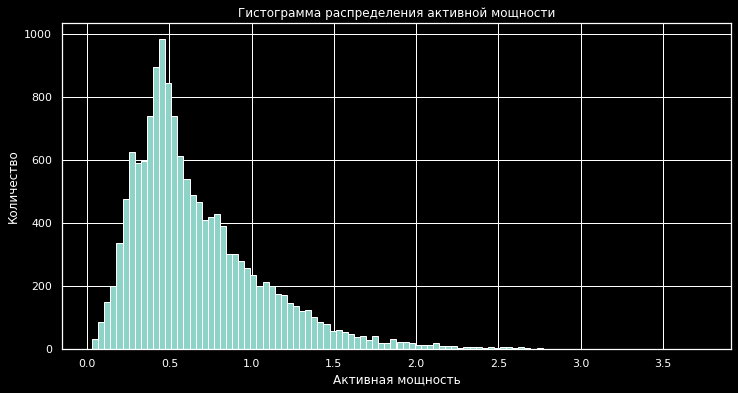

In [ ]:
data_arc['active_power'].hist(bins=100)
plt.title('Гистограмма распределения активной мощности')
plt.ylabel('Количество')
plt.xlabel('Активная мощность')
plt.show()

Активная мощность распредлена нормально присутствует «тяжелый» правый хвост, выбросов нет.

In [ ]:
display(data_arc['reactive_power'].describe())

count    14876.000000
mean         0.452592
std          5.878702
min       -715.504924
25%          0.290991
50%          0.415962
75%          0.637371
max          2.676388
Name: reactive_power, dtype: float64

В данных есть выбросы посмотрим на них

In [ ]:
data_arc[data_arc['reactive_power'] <= 0]

,key,start_heating,end_heating,active_power,reactive_power
9780,2116,2019-07-24 00:44:48,2019-07-24 00:46:37,0.495782,-715.504924


Удалим данный выброс

In [ ]:
data_arc = data_arc[data_arc['reactive_power'] > 0]

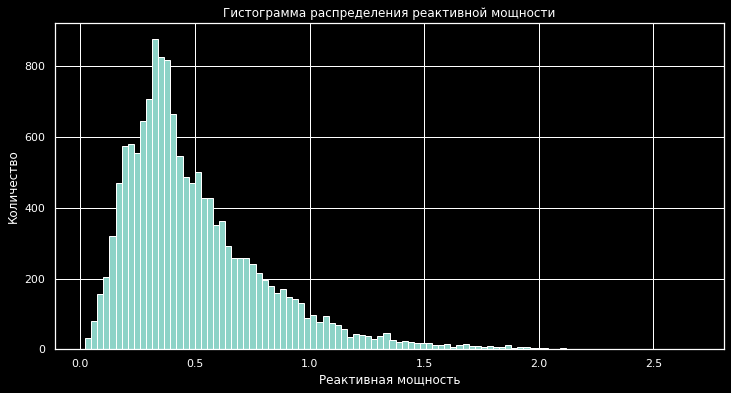

In [ ]:
data_arc['reactive_power'].hist(bins=100)
plt.title('Гистограмма распределения реактивной мощности')
plt.ylabel('Количество')
plt.xlabel('Реактивная мощность')
plt.show()

Данное распредление имеет схожий вид с распредлением актвиноый мощности, выбросов не осталось.

В data_arc отсутствуют пропуски и дубликаты. Выброс у партии 2116 удален.

### Подаче сыпучих материалов (объём)

In [ ]:
data_info(data_bulk)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB
Количество дубликатов 0


(None,
 None,
 None,
 key           0
 Bulk 1     2877
 Bulk 2     3107
 Bulk 3     1831
 Bulk 4     2115
 Bulk 5     3052
 Bulk 6     2553
 Bulk 7     3104
 Bulk 8     3128
 Bulk 9     3110
 Bulk 10    2953
 Bulk 11    2952
 Bulk 12     679
 Bulk 13    3111
 Bulk 14     323
 Bulk 15     881
 dtype: int64)

In [ ]:
# Заменим все пропуски нулями
data_bulk = data_bulk.fillna(value=0)

In [ ]:
#check
data_bulk.isna().sum().sum()

0

In [ ]:
#приведем названия столбцов в соответствии со "змеиным" регистром
data_bulk.columns = data_bulk.columns.str.lower()
data_bulk.columns = [x.replace(" ", "_") for x in data_bulk.columns]

In [ ]:
#check
data_bulk.head()

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
0,1,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0
1,2,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0
2,3,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0
3,4,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0
4,5,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0


Построим диаграммы размаха по bulk

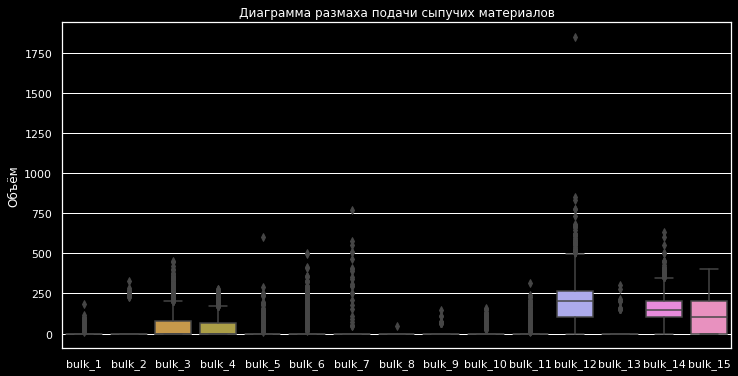

In [ ]:
sns.boxplot(data=(data_bulk.drop('key', axis=1)))\
.set(title='Диаграмма размаха подачи сыпучих материалов',
    ylabel='Объём');

Как мы можем видеть по диаграмме некоторые элементы практически не участвуют в процессе

Посмотрим на выброс 

In [ ]:
data_bulk[data_bulk['bulk_12']>1000]

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
303,322,185.0,0.0,101.0,58.0,0.0,0.0,406.0,0.0,0.0,0.0,0.0,1849.0,0.0,636.0,0.0


Оставим все как есть, возможно такое значение обусловлено технологическим процессом.

### Подаче сыпучих материалов (время)

In [ ]:
data_info(data_bulk_time)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB
Количество дубликатов 0


(None,
 None,
 None,
 key           0
 Bulk 1     2877
 Bulk 2     3107
 Bulk 3     1831
 Bulk 4     2115
 Bulk 5     3052
 Bulk 6     2553
 Bulk 7     3104
 Bulk 8     3128
 Bulk 9     3110
 Bulk 10    2953
 Bulk 11    2952
 Bulk 12     679
 Bulk 13    3111
 Bulk 14     323
 Bulk 15     881
 dtype: int64)

In [ ]:
#приведем названия столбцов в соответствии со "змеиным" регистром
data_bulk_time.columns = data_bulk_time.columns.str.lower()
data_bulk_time.columns = [x.replace(" ", "_") for x in data_bulk_time.columns]

In [ ]:
#check
data_bulk.columns

Index(['key', 'bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6',
       'bulk_7', 'bulk_8', 'bulk_9', 'bulk_10', 'bulk_11', 'bulk_12',
       'bulk_13', 'bulk_14', 'bulk_15'],
      dtype='object')

### Продувке сплава газом

In [ ]:
data_info(data_gas)

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB
Количество дубликатов 0


(None,
 None,
 None,
 key      0
 Газ 1    0
 dtype: int64)

In [ ]:
data_gas = data_gas.rename(columns={'Газ 1': 'gaz_1'})

[Text(0.5, 0, 'Объем газа')]

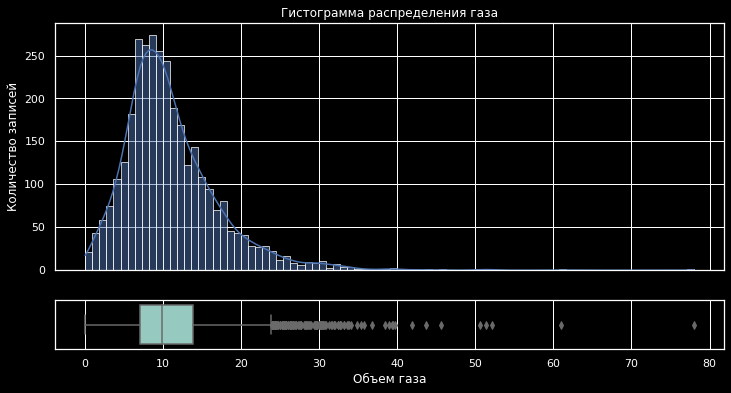

In [ ]:
_, [_hist, _box] = plt.subplots(2, 1,
                                     sharex=True,
                                     gridspec_kw=dict(height_ratios=[5,1]))
hist = sns.histplot(data=data_gas, x='gaz_1', kde=True, ax=_hist)
box = sns.boxplot(data=data_gas, x='gaz_1', orient='h', ax=_box)
hist.set(title='Гистограмма распределения газа',
         ylabel='Количество записей')
box.set(xlabel='Объем газа')

Посмотрим на значения > 50 

In [ ]:
data_gas[data_gas['gaz_1']>=50]

,key,gaz_1
116,117,50.581035
277,280,60.935689
319,322,77.995040
2107,2110,52.142373
2567,2570,51.380229


Возможно было необходимо интенсивное перемешивание, оставим данные как есть

### Результаты измерения температуры

In [ ]:
data_info(data_temp)

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           15907 non-null  int64  
 1   Время замера  15907 non-null  object 
 2   Температура   13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB
Количество дубликатов 0


(None,
 None,
 None,
 key                0
 Время замера       0
 Температура     2901
 dtype: int64)

In [ ]:
#переименуем столбцы
data_temp = data_temp.rename(columns={'Время замера': 'time', 'Температура': 'temperature'})

В столбце температура есть пропуски, пока их трогать не будем. Почистили выбросы. 

In [ ]:
#check
data_temp.columns

Index(['key', 'time', 'temperature'], dtype='object')

In [ ]:
#изменим тип данных
data_temp['time'] = data_temp['time'].apply(pd.to_datetime)

In [ ]:
#check
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   key          15907 non-null  int64         
 1   time         15907 non-null  datetime64[ns]
 2   temperature  13006 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 372.9 KB


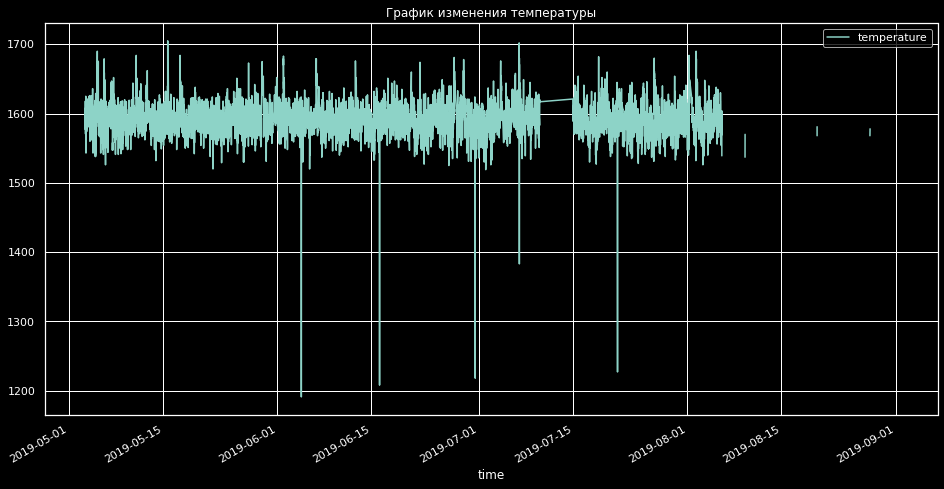

In [ ]:
data_temp.plot(x='time', y='temperature', figsize=(16,8))
plt.title('График изменения температуры')
plt.show()

Посмотрим на выбросы

In [ ]:
data_temp[data_temp['temperature'] < 1500]

,key,time,temperature
4350,867,2019-06-04 14:21:00,1191.0
5978,1214,2019-06-16 05:32:00,1208.0
7958,1619,2019-06-30 11:03:54,1218.0
8913,1818,2019-07-07 00:30:49,1383.0
8914,1818,2019-07-07 00:31:40,1383.0
10127,2052,2019-07-21 14:51:40,1227.0
12564,2561,2019-08-08 07:34:15,1204.0


Скорее всего в эти даты происходили какие либо технические сбои, удалим эти данные

In [ ]:
data_temp_clean = data_temp[data_temp['temperature'] >= 1500]

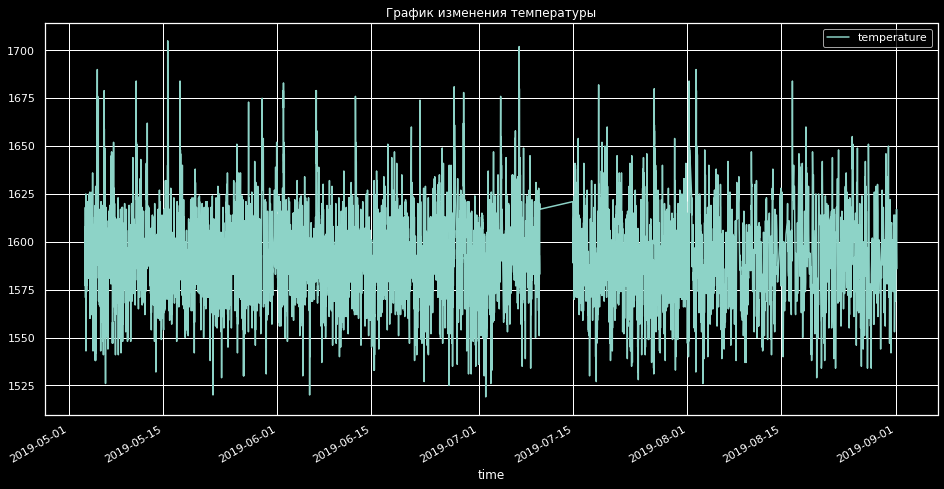

In [ ]:
data_temp_clean.plot(x='time', y='temperature', figsize=(16,8))
plt.title('График изменения температуры')
plt.show()

/tmp/ipykernel_31/2910498434.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_temp_clean['temperature_mean'] = data_temp_clean['temperature'].rolling(24).mean()


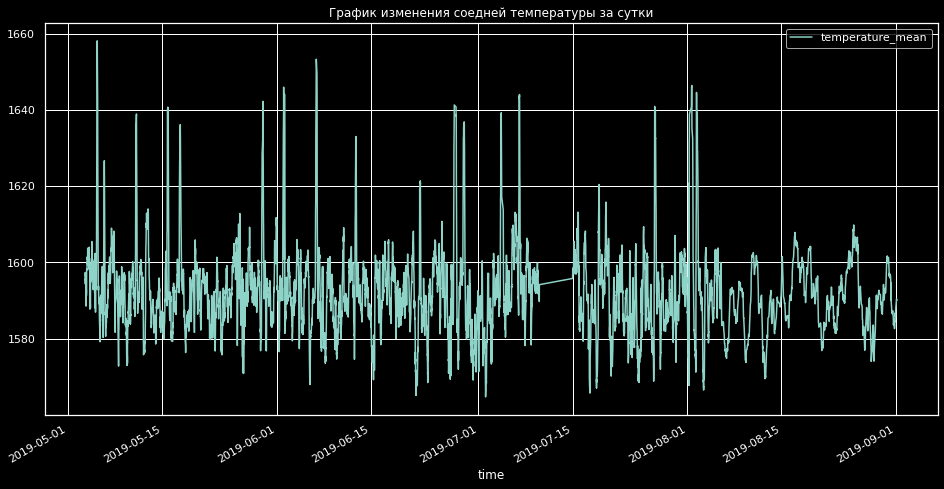

In [ ]:
data_temp_clean['temperature_mean'] = data_temp_clean['temperature'].rolling(24).mean()
data_temp_clean.plot(x='time', y='temperature_mean', figsize=(16,8))
plt.title('График изменения соедней температуры за сутки')
plt.show()

### Проволочные материалы (объём)

In [ ]:
data_info(data_wire)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB
Количество дубликатов 0


(None,
 None,
 None,
 key          0
 Wire 1      26
 Wire 2    2002
 Wire 3    3018
 Wire 4    3067
 Wire 5    3080
 Wire 6    3008
 Wire 7    3070
 Wire 8    3062
 Wire 9    3052
 dtype: int64)

In [ ]:
#приведем названия столбцов в соответствии со "змеиным" регистром
data_wire.columns = data_wire.columns.str.lower()
data_wire.columns = [x.replace(" ", "_") for x in data_wire.columns]

In [ ]:
#check
data_wire.columns

Index(['key', 'wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_5', 'wire_6',
       'wire_7', 'wire_8', 'wire_9'],
      dtype='object')

In [ ]:
#Заменим все пропуски нулями
data_wire = data_wire.fillna(value=0)

In [ ]:
#check
data_wire.isna().sum().sum()

0

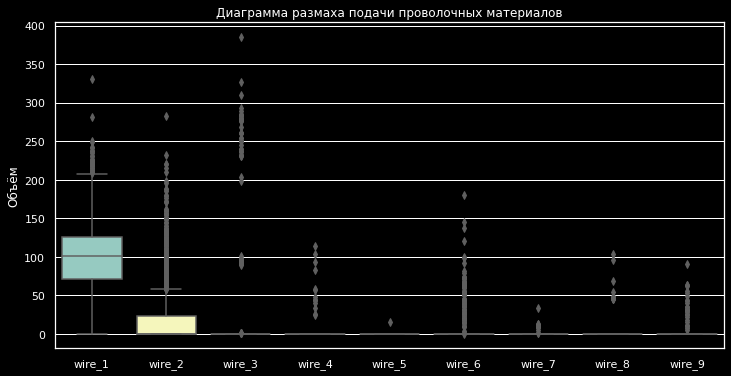

In [ ]:
sns.boxplot(data=(data_wire.drop('key', axis=1)))\
.set(title='Диаграмма размаха подачи проволочных материалов',
    ylabel='Объём');

По диаграмме видно, что некоторые материалы практически не участвуют в тех. процессе.

Пропуски заполнили на нули. По диаграмме размаха видны выбросы, но пока оставим все как есть.

### Проволочные материалы (время)

In [ ]:
data_info(data_wire_time)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB
Количество дубликатов 0


(None,
 None,
 None,
 key          0
 Wire 1      26
 Wire 2    2002
 Wire 3    3018
 Wire 4    3067
 Wire 5    3080
 Wire 6    3008
 Wire 7    3070
 Wire 8    3062
 Wire 9    3052
 dtype: int64)

In [ ]:
#приведем названия столбцов в соответствии со "змеиным" регистром
data_wire_time.columns = data_wire_time.columns.str.lower()
data_wire_time.columns = [x.replace(" ", "_") for x in data_wire_time.columns]

In [ ]:
#check
data_wire_time.columns

Index(['key', 'wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_5', 'wire_6',
       'wire_7', 'wire_8', 'wire_9'],
      dtype='object')

Есть пропуски, как и в data_bulk_time они связаны с тем, что в опредленной партии подаются только определенные компоненты.

## Подготовка данных

### Полная мощность

In [ ]:
data_arc.head()

,key,start_heating,end_heating,active_power,reactive_power
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397


Рассчитаем продолжительность нагрева

In [ ]:
data_arc['heating_duration'] = data_arc['end_heating'] - data_arc['start_heating']

In [ ]:
#check
data_arc.head()

,key,start_heating,end_heating,active_power,reactive_power,heating_duration
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084,0 days 00:03:48
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285,0 days 00:03:05
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805,0 days 00:02:52
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669,0 days 00:06:05
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397,0 days 00:02:28


Переведем время нагрева в секунды

In [ ]:
#Функция для пересчета вреени
def seconds(row):
    return row.total_seconds()
data_arc['heating_duration'] = data_arc['heating_duration'].apply(seconds)

In [ ]:
#check
data_arc.head()

,key,start_heating,end_heating,active_power,reactive_power,heating_duration
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084,228.0
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285,185.0
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805,172.0
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669,365.0
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397,148.0


Рассчитаем полную мощность

In [ ]:
data_arc['full_power'] = (data_arc['active_power']**2 + data_arc['reactive_power']**2)**0.5

In [ ]:
#check
data_arc.head()

,key,start_heating,end_heating,active_power,reactive_power,heating_duration,full_power
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084,228.0,1.193639
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285,185.0,0.959010
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805,172.0,0.896038
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669,365.0,1.970470
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397,148.0,0.807239


Просуммируем данные по партии

In [ ]:
df = data_arc.groupby('key')[['full_power', 'heating_duration']].sum().reset_index()
df.head()

,key,full_power,heating_duration
0,1,5.826395,1098.0
1,2,3.649216,811.0
2,3,2.989534,655.0
3,4,3.814962,741.0
4,5,4.035758,869.0


Посчитаем количество нагревов и добавим в df

In [ ]:
df = pd.merge(df, data_arc.groupby('key')['start_heating'].count().reset_index(), on='key')
df.head()

,key,full_power,heating_duration,start_heating
0,1,5.826395,1098.0,5
1,2,3.649216,811.0,4
2,3,2.989534,655.0,5
3,4,3.814962,741.0,4
4,5,4.035758,869.0,4


In [ ]:
df = df.rename(columns={'start_heating': 'heating_count'})

In [ ]:
#check
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   key               3214 non-null   int64  
 1   full_power        3214 non-null   float64
 2   heating_duration  3214 non-null   float64
 3   heating_count     3214 non-null   int64  
dtypes: float64(2), int64(2)
memory usage: 125.5 KB


### Измерения температур

In [ ]:
data_temp

,key,time,temperature
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0
...,...,...,...
15902,3241,2019-09-01 04:03:30,1586.0
15903,3241,2019-09-01 04:16:12,NaN
15904,3241,2019-09-01 04:22:39,NaN
15905,3241,2019-09-01 04:33:42,NaN


In [ ]:
# Заменим все пропущенные значения температуры нулями
data_temp = data_temp.fillna(value=0)

Найдем начальную темпертуру каждой партии

In [ ]:
temp_start = data_temp.groupby('key')[['time', 'temperature']].first().reset_index()
temp_start

,key,time,temperature
0,1,2019-05-03 11:16:18,1571.0
1,2,2019-05-03 11:37:27,1581.0
2,3,2019-05-03 12:13:17,1596.0
3,4,2019-05-03 12:52:57,1601.0
4,5,2019-05-03 13:23:19,1576.0
...,...,...,...
3211,3237,2019-08-31 22:44:04,1569.0
3212,3238,2019-08-31 23:30:31,1584.0
3213,3239,2019-09-01 01:31:47,1598.0
3214,3240,2019-09-01 02:39:01,1617.0


Найдем конечную темпертуру каждой партии

In [ ]:
temp_end = data_temp.groupby('key')[['time', 'temperature']].last().reset_index()
temp_end

,key,time,temperature
0,1,2019-05-03 11:30:39,1613.0
1,2,2019-05-03 11:59:12,1602.0
2,3,2019-05-03 12:34:57,1599.0
3,4,2019-05-03 12:59:25,1625.0
4,5,2019-05-03 13:36:01,1602.0
...,...,...,...
3211,3237,2019-08-31 23:05:43,0.0
3212,3238,2019-08-31 23:43:00,0.0
3213,3239,2019-09-01 02:24:15,0.0
3214,3240,2019-09-01 03:35:16,0.0


Объединим таблицы

In [ ]:
temp = pd.merge(temp_start, temp_end, on='key', how='left', suffixes=('_start', '_end'))
temp

,key,time_start,temperature_start,time_end,temperature_end
0,1,2019-05-03 11:16:18,1571.0,2019-05-03 11:30:39,1613.0
1,2,2019-05-03 11:37:27,1581.0,2019-05-03 11:59:12,1602.0
2,3,2019-05-03 12:13:17,1596.0,2019-05-03 12:34:57,1599.0
3,4,2019-05-03 12:52:57,1601.0,2019-05-03 12:59:25,1625.0
4,5,2019-05-03 13:23:19,1576.0,2019-05-03 13:36:01,1602.0
...,...,...,...,...,...
3211,3237,2019-08-31 22:44:04,1569.0,2019-08-31 23:05:43,0.0
3212,3238,2019-08-31 23:30:31,1584.0,2019-08-31 23:43:00,0.0
3213,3239,2019-09-01 01:31:47,1598.0,2019-09-01 02:24:15,0.0
3214,3240,2019-09-01 02:39:01,1617.0,2019-09-01 03:35:16,0.0


Найдем партии где проводилось только одно измерение

In [ ]:
temp[temp['time_start'] == temp['time_end']]

,key,time_start,temperature_start,time_end,temperature_end
192,195,2019-05-10 14:10:23,1583.0,2019-05-10 14:10:23,1583.0
276,279,2019-05-13 23:07:28,1603.0,2019-05-13 23:07:28,1603.0


Удалим данные партии

In [ ]:
temp = temp[temp['time_start'] != temp['time_end']]
temp

,key,time_start,temperature_start,time_end,temperature_end
0,1,2019-05-03 11:16:18,1571.0,2019-05-03 11:30:39,1613.0
1,2,2019-05-03 11:37:27,1581.0,2019-05-03 11:59:12,1602.0
2,3,2019-05-03 12:13:17,1596.0,2019-05-03 12:34:57,1599.0
3,4,2019-05-03 12:52:57,1601.0,2019-05-03 12:59:25,1625.0
4,5,2019-05-03 13:23:19,1576.0,2019-05-03 13:36:01,1602.0
...,...,...,...,...,...
3211,3237,2019-08-31 22:44:04,1569.0,2019-08-31 23:05:43,0.0
3212,3238,2019-08-31 23:30:31,1584.0,2019-08-31 23:43:00,0.0
3213,3239,2019-09-01 01:31:47,1598.0,2019-09-01 02:24:15,0.0
3214,3240,2019-09-01 02:39:01,1617.0,2019-09-01 03:35:16,0.0


Найдем партии где финальная температура равно 0

In [ ]:
temp[temp['temperature_end'] == 0]

,key,time_start,temperature_start,time_end,temperature_end
2477,2500,2019-08-06 03:11:31,1539.0,2019-08-06 03:28:21,0.0
2478,2501,2019-08-06 03:44:42,1587.0,2019-08-06 04:31:14,0.0
2479,2502,2019-08-06 04:45:26,1583.0,2019-08-06 05:12:20,0.0
2480,2503,2019-08-06 05:32:06,1603.0,2019-08-06 06:07:35,0.0
2481,2504,2019-08-06 06:35:39,1583.0,2019-08-06 07:04:16,0.0
...,...,...,...,...,...
3211,3237,2019-08-31 22:44:04,1569.0,2019-08-31 23:05:43,0.0
3212,3238,2019-08-31 23:30:31,1584.0,2019-08-31 23:43:00,0.0
3213,3239,2019-09-01 01:31:47,1598.0,2019-09-01 02:24:15,0.0
3214,3240,2019-09-01 02:39:01,1617.0,2019-09-01 03:35:16,0.0


Удалим такие партии

In [ ]:
temp = temp[temp['temperature_end'] != 0]
temp

,key,time_start,temperature_start,time_end,temperature_end
0,1,2019-05-03 11:16:18,1571.0,2019-05-03 11:30:39,1613.0
1,2,2019-05-03 11:37:27,1581.0,2019-05-03 11:59:12,1602.0
2,3,2019-05-03 12:13:17,1596.0,2019-05-03 12:34:57,1599.0
3,4,2019-05-03 12:52:57,1601.0,2019-05-03 12:59:25,1625.0
4,5,2019-05-03 13:23:19,1576.0,2019-05-03 13:36:01,1602.0
...,...,...,...,...,...
2472,2495,2019-08-06 00:35:45,1570.0,2019-08-06 00:54:42,1591.0
2473,2496,2019-08-06 01:02:54,1554.0,2019-08-06 01:29:52,1591.0
2474,2497,2019-08-06 01:41:53,1571.0,2019-08-06 01:53:50,1589.0
2475,2498,2019-08-06 02:03:49,1591.0,2019-08-06 02:25:31,1594.0


Удалим данные о времени из таблицы

In [ ]:
temp_result = temp[['key', 'temperature_start', 'temperature_end']]
temp_result

,key,temperature_start,temperature_end
0,1,1571.0,1613.0
1,2,1581.0,1602.0
2,3,1596.0,1599.0
3,4,1601.0,1625.0
4,5,1576.0,1602.0
...,...,...,...
2472,2495,1570.0,1591.0
2473,2496,1554.0,1591.0
2474,2497,1571.0,1589.0
2475,2498,1591.0,1594.0


### Сыпучие материалы

Рассчитаем сумму материалов по партии и количесвто bulk в партии 

In [ ]:
data_bulk

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
0,1,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0
1,2,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0
2,3,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0
3,4,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0
4,5,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3124,3237,0.0,0.0,170.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,252.0,0.0,130.0,206.0
3125,3238,0.0,0.0,126.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,254.0,0.0,108.0,106.0
3126,3239,0.0,0.0,0.0,0.0,0.0,114.0,0.0,0.0,0.0,0.0,0.0,158.0,0.0,270.0,88.0
3127,3240,0.0,0.0,0.0,0.0,0.0,26.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,192.0,54.0


In [ ]:
#функция для подсчета суммы
def make_sum(row, columns):
    bulk_sum = 0
    for col in columns:
        bulk_sum += row[col]
    return bulk_sum
#функция для подсчета кол-ва элементов в партии
def make_count (row, columns):
    bulk_count = 0
    for col in columns:
        if row[col] != 0:
            bulk_count += 1
    return bulk_count

In [ ]:
bulk = data_bulk.columns[1:].to_list()
bulk

['bulk_1',
 'bulk_2',
 'bulk_3',
 'bulk_4',
 'bulk_5',
 'bulk_6',
 'bulk_7',
 'bulk_8',
 'bulk_9',
 'bulk_10',
 'bulk_11',
 'bulk_12',
 'bulk_13',
 'bulk_14',
 'bulk_15']

In [ ]:
data_bulk['bulk_sum'] = data_bulk.apply(make_sum, columns=bulk, axis=1)
data_bulk['bulk_count'] = data_bulk.apply(make_count, columns=bulk, axis=1)
data_bulk

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,bulk_sum,bulk_count
0,1,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0,553.0,4
1,2,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0,582.0,4
2,3,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0,544.0,4
3,4,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0,595.0,4
4,5,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0,584.0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3124,3237,0.0,0.0,170.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,252.0,0.0,130.0,206.0,758.0,4
3125,3238,0.0,0.0,126.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,254.0,0.0,108.0,106.0,594.0,4
3126,3239,0.0,0.0,0.0,0.0,0.0,114.0,0.0,0.0,0.0,0.0,0.0,158.0,0.0,270.0,88.0,630.0,4
3127,3240,0.0,0.0,0.0,0.0,0.0,26.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,192.0,54.0,272.0,3


Проверим какие bulk не участвутю в процессе (сумма = 0)

In [ ]:
data_bulk.sum()

key           5082696.0
bulk_1           9889.0
bulk_2           5567.0
bulk_3         147815.0
bulk_4         105856.0
bulk_5           8241.0
bulk_6          68501.0
bulk_7           7640.0
bulk_8             49.0
bulk_9           1450.0
bulk_10         14658.0
bulk_11         13597.0
bulk_12        638154.0
bulk_13          3260.0
bulk_14        477819.0
bulk_15        360834.0
bulk_sum      1863330.0
bulk_count      11159.0
dtype: float64

Оставим все признаки

### Проволочные материалы

In [ ]:
data_wire.head()

,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
0,1,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Рассчитаем сумму материалов по партии и количесвто wire в партии

In [ ]:
wire = data_wire.columns[1:].to_list()
wire

['wire_1',
 'wire_2',
 'wire_3',
 'wire_4',
 'wire_5',
 'wire_6',
 'wire_7',
 'wire_8',
 'wire_9']

In [ ]:
data_wire['wire_sum'] = data_wire.apply(make_sum, columns=wire, axis=1)
data_wire['wire_count'] = data_wire.apply(make_count, columns=wire, axis=1)
data_wire

,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9,wire_sum,wire_count
0,1,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60.059998,1
1,2,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,96.052315,1
2,3,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,91.160157,1
3,4,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,89.063515,1
4,5,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0,98.352796,2
...,...,...,...,...,...,...,...,...,...,...,...,...
3076,3237,38.088959,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,38.088959,1
3077,3238,56.128799,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,56.128799,1
3078,3239,143.357761,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,143.357761,1
3079,3240,34.070400,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,34.070400,1


Проверим какие wire не участвутю в процессе (сумма = 0)

In [ ]:
data_wire.sum()

key           5.001777e+06
wire_1        3.082368e+05
wire_2        5.457293e+04
wire_3        1.193741e+04
wire_4        8.041998e+02
wire_5        1.513200e+01
wire_6        3.505239e+03
wire_7        1.104291e+02
wire_8        1.018879e+03
wire_9        9.905168e+02
wire_sum      3.811916e+05
wire_count    4.344000e+03
dtype: float64

Оставим все признаки

### Сводная таблица данных

Объединим все признаки в одну таблицу

In [ ]:
#объединяем через inner, чтобы удалить партии в которых мы удаляли выбросы
df = df.merge(temp_result, on='key').merge(data_bulk, on='key').merge(data_wire, on='key')
df

,key,full_power,heating_duration,heating_count,temperature_start,temperature_end,bulk_1,bulk_2,bulk_3,bulk_4,...,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9,wire_sum,wire_count
0,1,5.826395,1098.0,5,1571.0,1613.0,0.0,0.0,0.0,43.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60.059998,1
1,2,3.649216,811.0,4,1581.0,1602.0,0.0,0.0,0.0,73.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,96.052315,1
2,3,2.989534,655.0,5,1596.0,1599.0,0.0,0.0,0.0,34.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,91.160157,1
3,4,3.814962,741.0,4,1601.0,1625.0,0.0,0.0,0.0,81.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,89.063515,1
4,5,4.035758,869.0,4,1576.0,1602.0,0.0,0.0,0.0,78.0,...,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0,98.352796,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2326,2495,3.986869,723.0,4,1570.0,1591.0,0.0,0.0,21.0,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,89.150879,1
2327,2496,5.057033,940.0,6,1554.0,1591.0,0.0,0.0,0.0,63.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,114.179527,1
2328,2497,2.885017,569.0,3,1571.0,1589.0,0.0,0.0,0.0,85.0,...,9.04800,0.0,0.0,0.0,0.0,0.0,0.0,0.0,103.134723,2
2329,2498,4.143749,750.0,5,1591.0,1594.0,0.0,0.0,90.0,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,118.110717,1


Удалим столбец key, так как он не представляет пользы для обучения моделей

In [ ]:
df = df.drop('key', axis=1)

In [ ]:
#check
df.head()

,full_power,heating_duration,heating_count,temperature_start,temperature_end,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,...,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9,wire_sum,wire_count
0,5.826395,1098.0,5,1571.0,1613.0,0.0,0.0,0.0,43.0,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60.059998,1
1,3.649216,811.0,4,1581.0,1602.0,0.0,0.0,0.0,73.0,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,96.052315,1
2,2.989534,655.0,5,1596.0,1599.0,0.0,0.0,0.0,34.0,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,91.160157,1
3,3.814962,741.0,4,1601.0,1625.0,0.0,0.0,0.0,81.0,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,89.063515,1
4,4.035758,869.0,4,1576.0,1602.0,0.0,0.0,0.0,78.0,0.0,...,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0,98.352796,2


In [ ]:
#проверим df на пропуски
df.isna().sum().sum()

0

Выделим target и разделим данные на обучающую и тестовую выборки

Данные для обучения готовы

## Подготовка моделей

### Линейная регрессия

Проверим данные на мультиколлиниарность

In [ ]:
corr_df = df.copy()
abs(corr_df.corr()['temperature_end']) > 0.6

full_power           False
heating_duration     False
heating_count        False
temperature_start    False
temperature_end       True
bulk_1               False
bulk_2               False
bulk_3               False
bulk_4               False
bulk_5               False
bulk_6               False
bulk_7               False
bulk_8               False
bulk_9               False
bulk_10              False
bulk_11              False
bulk_12              False
bulk_13              False
bulk_14              False
bulk_15              False
bulk_sum             False
bulk_count           False
wire_1               False
wire_2               False
wire_3               False
wire_4               False
wire_5               False
wire_6               False
wire_7               False
wire_8               False
wire_9               False
wire_sum             False
wire_count           False
Name: temperature_end, dtype: bool

<AxesSubplot:>

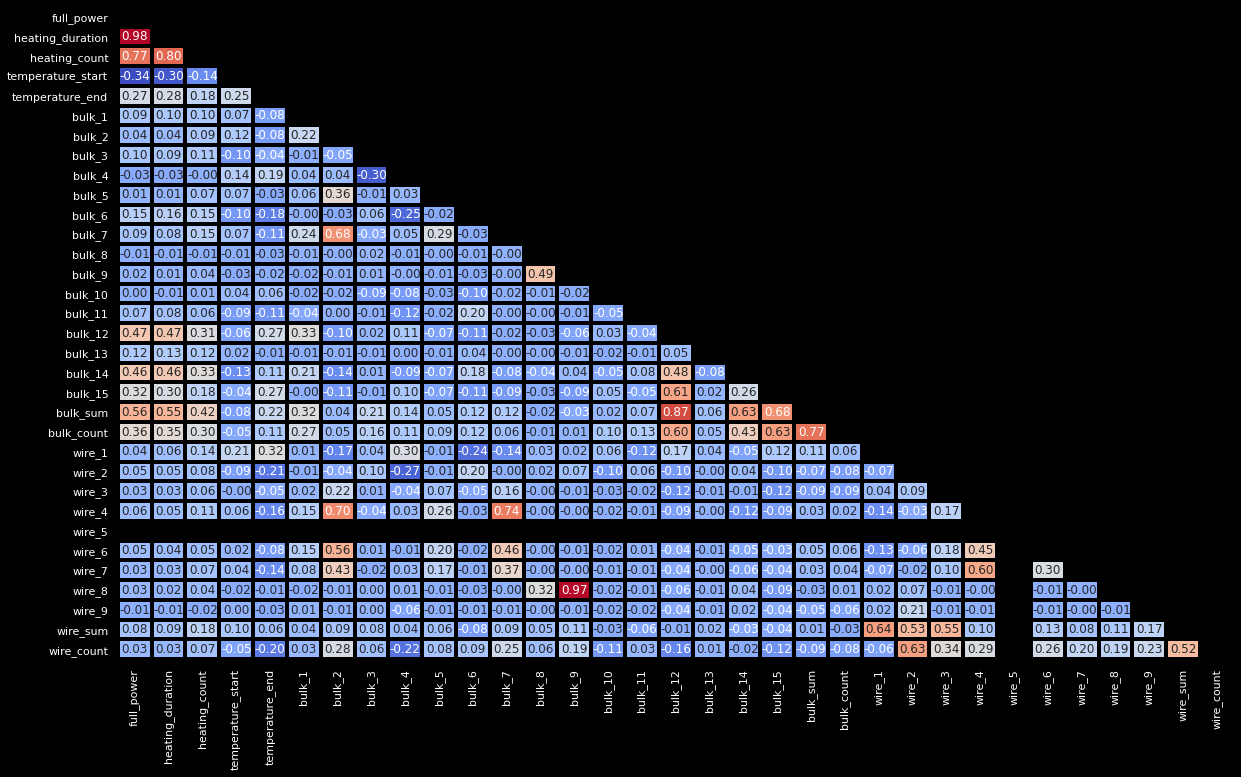

In [ ]:
fig, ax = plt.subplots(figsize=(20, 12))
sns.heatmap(corr_df.corr(),annot=True,cmap= 'coolwarm', linewidths=3, linecolor='black', 
            cbar=False,fmt='.2f', mask=np.triu(corr_df.corr()))\
.set(title='Тепловая карта признаков')
plt.show()

Все признаки прошли проверку на мультиколлиниарность (порог 0.6). По тепловой карте видно, что wire_5 не участвует в процессе. Удалим данный признак, а также удалим сильно коррелирующие признаки и мало влияющие.

In [ ]:
X = df.drop(['temperature_end', 'wire_5', 'heating_duration','bulk_8', 'wire_8', 'bulk_9'],  axis=1)
y = df['temperature_end']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=11122)

In [ ]:
print(X_train.shape, X_test.shape)

(1748, 27) (583, 27)


In [ ]:
lr = LinearRegression(normalize='True')
result_lr = cross_val_score(lr, X_train, y_train, scoring='neg_mean_absolute_error').mean()
print('MAE модели линейной регрессии:', abs(result_lr))

MAE модели линейной регрессии: 7.748030624082273


### LightGBM

In [ ]:
lgbm = LGBMRegressor(random_state=11122)
params_lgbm = {'n_estimators' : [10, 100, 300, 500, 1000],
               'max_depth' : range(1, 10),
               'learning_rate': [0.03, 0.1, 0.5]}

grid_lgbm = GridSearchCV(estimator=lgbm, param_grid=params_lgbm, scoring='neg_mean_absolute_error', cv=5)
grid_lgbm.fit(X_train, y_train)
print('Best MAE: %.2f'%abs(grid_lgbm.best_score_), ' Best Params : ', str(grid_lgbm.best_params_))

Best MAE: 6.22  Best Params :  {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100}


### XGBoost

In [ ]:
xgb = XGBRegressor(random_state=11122, verbosity=0)
params_xgb = {'eta' : [0.01, 0.1, 0.3, 0.5],
               'max_depth' : range(1, 10)}

grid_xgb = GridSearchCV(estimator=xgb, param_grid=params_xgb, scoring='neg_mean_absolute_error', cv=5)
grid_xgb.fit(X_train, y_train)
print('Best MAE: %.2f'%abs(grid_xgb.best_score_), ' Best Params : ', grid_xgb.best_params_)

Best MAE: 6.11  Best Params :  {'eta': 0.1, 'max_depth': 6}


### Catboost

In [ ]:
cat = CatBoostRegressor(silent=True, random_state=11122)
params_cat = {'iterations' : [10, 100, 1000],
               'depth' : range(1, 11, 3),
               'learning_rate': [0.03, 0.1]}

grid_cat = GridSearchCV(estimator=cat, param_grid=params_cat, scoring='neg_mean_absolute_error', cv=5)
grid_cat.fit(X_train, y_train)
print('Best MAE: %.2f'%abs(grid_cat.best_score_), ' Best Params : ', str(grid_cat.best_params_))

Best MAE: 6.02  Best Params :  {'depth': 4, 'iterations': 1000, 'learning_rate': 0.03}


Наилучший показатель MAE у Catboost. Протестируем данную модель.

### Тестирование модели Catboost

In [ ]:
best_model = grid_cat.best_estimator_
predictions = best_model.predict(X_test)
print('MAE best model:', round(mean_absolute_error(predictions, y_test), 2))

MAE best model: 6.02


Оценим важность признаков для модели

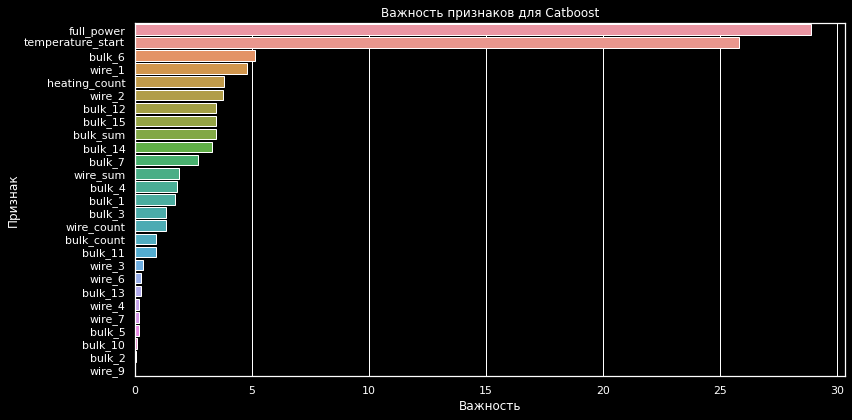

In [ ]:
feature_imp = pd.DataFrame(sorted(zip(best_model.feature_importances_,X_train)), columns=['Важность','Признак'])
sns.barplot(x="Важность", y="Признак", data=feature_imp.sort_values(by="Важность", ascending=False))
plt.title('Важность признаков для Catboost')
plt.tight_layout()
plt.show()

Как и следовало ожидать наиболее важныепризнаки для модели - это начальная температура и мощность нагрева. 

## Вывод

В ходе проекта разработа модель машинного обучения для оптимизации потребление электроэнергии на этапе обработки стали. Модель CatBoostRegressor показывает на тестовой выборке метрику MAE 6,02.

## Отчет о проделанной работе

1. Все пункты плана были выполнены в полном объеме. Цель работы достигнута.

2. Основная трудность заключалась в сопоставлении имеющихся данных. Для решении задачи, как задачи временных рядов, данных было недостаточною, а для решения в том виде, как было сделано, данные из датасетов bulk_time и wire_time не использовались. Данные по времени применялись только для формирования признаков для обучения моедли;

3. Ключевые шаги - это предобработка данных и формирование дополнительных признаков, так как данные шаги позволяют существенно улучшить метрики качества модели. В ходе предобработки данных были выявлены и удалены выбросы в data_arc и data_temp. На этапе формирования дополнительных признаков мы подготовили данные для улучшения качества обучения будующей модели, на снове имеющихся данных. Были расчитаны: полная мощность, количесвто нагревов, количесвто bulk и wire.

4. Итоговой моделью машинного обучения для оптимизации потребление электроэнергии на этапе обработки стали является CatBoostRegressor. Параметры модели: 'depth': 4, 'iterations': 1000, 'learning_rate': 0.03. Данная модель показывает на тестовой выборке метрику MAE 6,02.
Наиболее важными признаками для работы модели являются начальная температура процесса и полная мощность. 